# Time Series Analysis on Air Passengers Data

In [29]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# from matplotlib.pyplot import rcParams
plt.rcParams['figure.figsize'] = 10,6

## Importing the dataset

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

od.download('https://www.kaggle.com/chirag19/air-passengers')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 

Abort: 

In [30]:
df = pd.read_csv('./air-passengers/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [31]:
# Parse strings to datetime format

df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format = True)
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [32]:
# Indexing the dataset with 'Month' feature
indexed_df = df.set_index(['Month'])

In [33]:
indexed_df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [34]:
from datetime import datetime

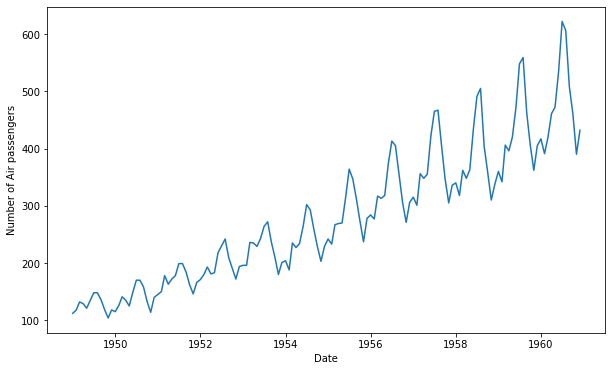

In [35]:
# Plot the graph

plt.xlabel('Date')
plt.ylabel('Number of Air passengers')
plt.plot(indexed_df)

The trend of the graph shows that the data is non-stationery. The mean is not constant so as the variance.

We have two methods to check the stationarity of the data.
1. Rolling statistics
2. ADCF - Augmented Dickey-Fuller test

### Determining rolling statistics 

In [36]:
# Calculating rolling mean and rolling std

rolmean = indexed_df.rolling(window=12).mean()
rolstd = indexed_df.rolling(window=12).std()

print(rolmean, rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


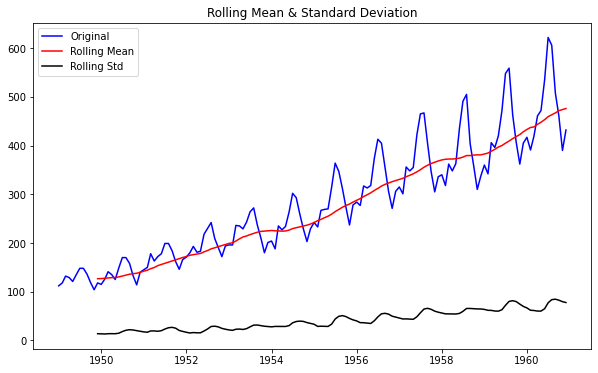

In [37]:
# Plot rolling statistics

orig = plt.plot(indexed_df, color='b', label='Original')
mean = plt.plot(rolmean, color='r', label='Rolling Mean')
std = plt.plot(rolstd, color='k', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Performing Dickey-Fuller test

In [38]:
# Importing adfuller
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller test:')
dftest = adfuller(indexed_df['#Passengers'], autolag='AIC') # Outputs stats params

# Converting Dickey-Fuller outputs to pandas series
df_output = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])

for key, value in dftest[4].items():
    df_output['Critical Value (%s)'%key] = value
    
print(df_output)

Results of Dickey-Fuller test:
Test Statistic            0.815369
p-value                   0.991880
#Lags used               13.000000
#Observations used      130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


The null hypothesis is that the data is non-stationary. As we got the p-value over 99% we can not reject the null hypothesis. That means the data is non-stationary.

### Log transformation

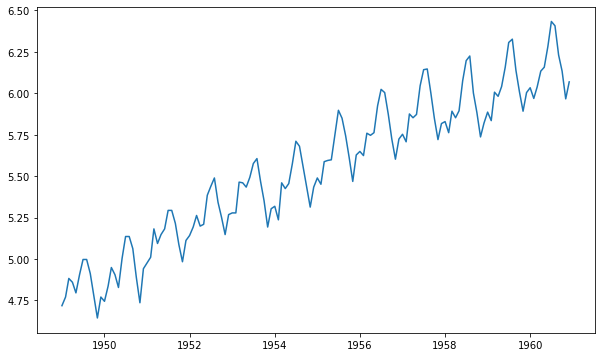

In [39]:
# Estimating the trend

# Applying the log transformation
ind_df_logscale = np.log(indexed_df)
plt.plot(ind_df_logscale)

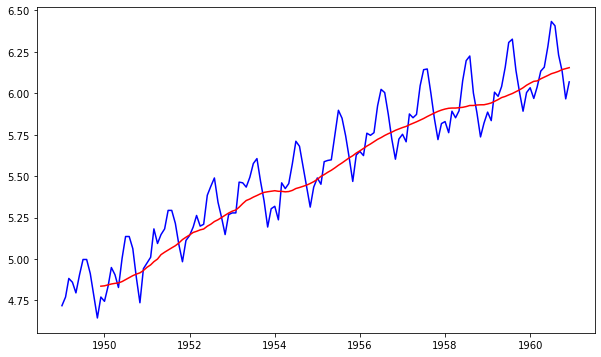

In [40]:
movingAverage = ind_df_logscale.rolling(window=12).mean()
movingStd = ind_df_logscale.rolling(window=12).std()

plt.plot(ind_df_logscale, color='b')
plt.plot(movingAverage, color='r')

From the above observation we can say that, even after log transformation the data is not stationary.

### Moving Average

In [41]:
# Get the difference between the moving and the actual no.of passengers

dfLogscaleMinusMA = ind_df_logscale - movingAverage
dfLogscaleMinusMA.head(15)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [42]:
# Removing the nan values

dfLogscaleMinusMA.dropna(inplace=True)
dfLogscaleMinusMA.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


In [43]:
def test_stationarity(timeseries):
    
    # Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='b', label='Original')
    mean = plt.plot(movingAverage, color='r', label='Rolling Mean')
    std = plt.plot(movingStd, color='k', label='Rolling Std')
    plt.legend()
    plt.show()
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#Observations used'])
    for key, value in dftest[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)
    

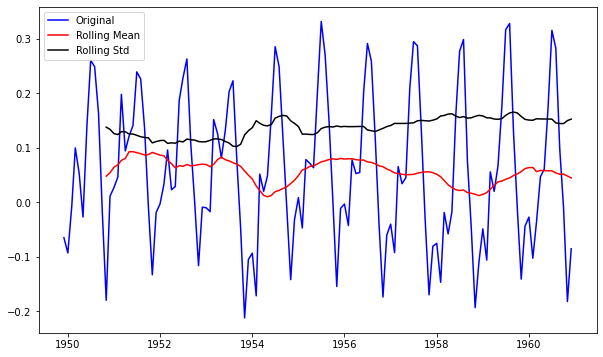

Results of Dickey-Fuller test:
Test Statistic           -3.162908
p-value                   0.022235
#Lags used               13.000000
#Observations used      119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


In [44]:
test_stationarity(dfLogscaleMinusMA)

From the above observation we can say that, the data is stationary. Also we can observe the p-value which is 2%. That means we can reject the null hypothesis.
### Exponential Decay Weighted Average:
Another method to get the stationarity of the data. Here we use Weighted Average instead of simple average.

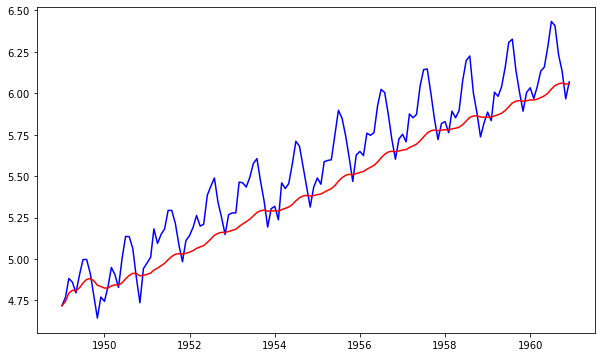

In [45]:
expDecayWAverage = ind_df_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()

plt.plot(ind_df_logscale, color='b')
plt.plot(expDecayWAverage, color='r')

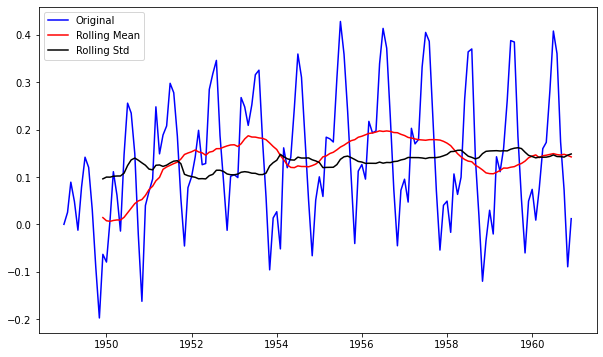

Results of Dickey-Fuller test:
Test Statistic           -3.601262
p-value                   0.005737
#Lags used               13.000000
#Observations used      130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [46]:
df_log_minus_mov_expDWA = ind_df_logscale - expDecayWAverage

# Checking the stationarity with the help of test_stationarity function
test_stationarity(df_log_minus_mov_expDWA)

From the above observation, we can say that the data is stationary. Which is also proven by the p-value 0.5%.

Now we know that our data is stationary. 

### Shifting:
We will shift the values in to the timeseries so that we can use it in the forecasting.

Here we are differentiating the timeseries once. That is D=1.

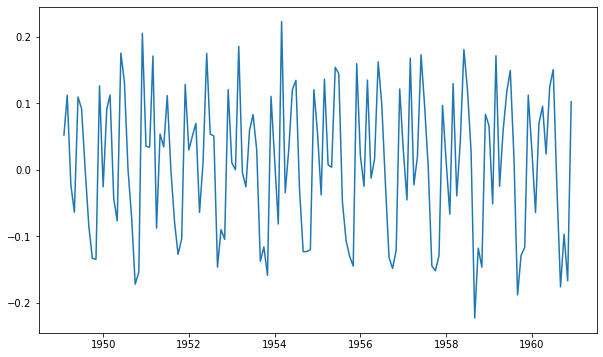

In [47]:
df_log_DiffShifting = ind_df_logscale - ind_df_logscale.shift()

plt.plot(df_log_DiffShifting)

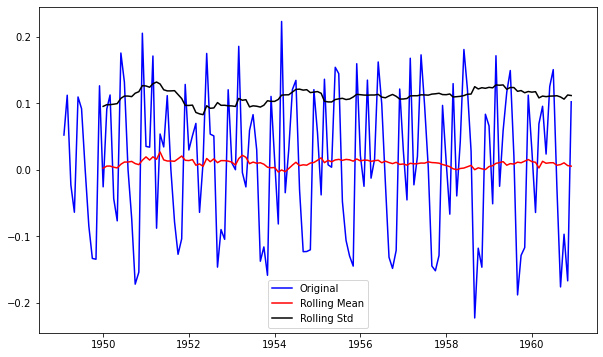

Results of Dickey-Fuller test:
Test Statistic           -2.717131
p-value                   0.071121
#Lags used               14.000000
#Observations used      128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [48]:
# Dropping the nan values
df_log_DiffShifting.dropna(inplace=True)

# Checking the stationarity with the help of test_stationarity function
test_stationarity(df_log_DiffShifting)

### Components of timeseries

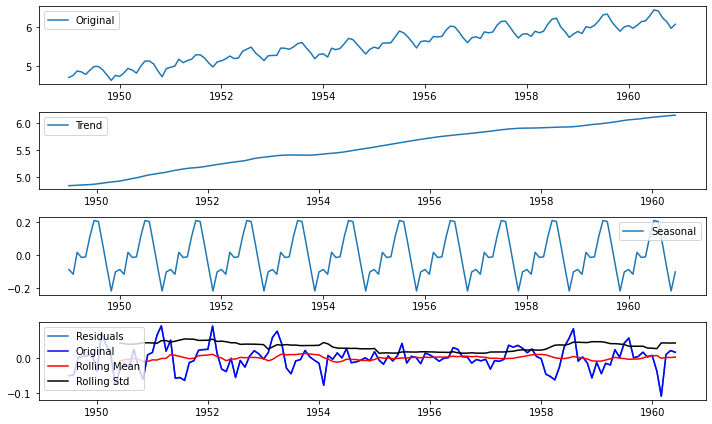

Results of Dickey-Fuller test:


KeyError: '#Passengers'

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ind_df_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid # Residuals are irregularities present in data

plt.subplot(411)
plt.plot(ind_df_logscale, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

test_stationarity(decomposedLogData)

Now let's check whether the noise(irregularities) is stationary or not.

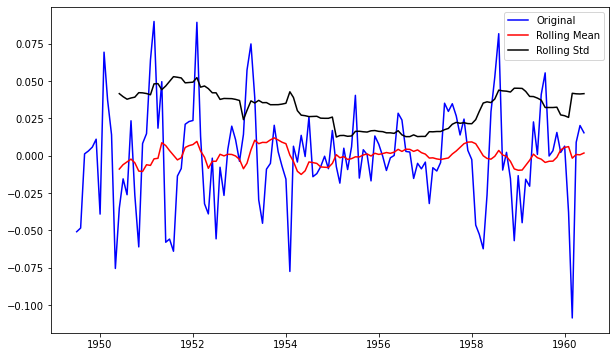

Results of Dickey-Fuller test:


KeyError: '#Passengers'

In [50]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

test_stationarity(decomposedLogData)

### PACF  and ACF
In order to calculate the value of P we need PACF graph and for Q we need ACF graph.

C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


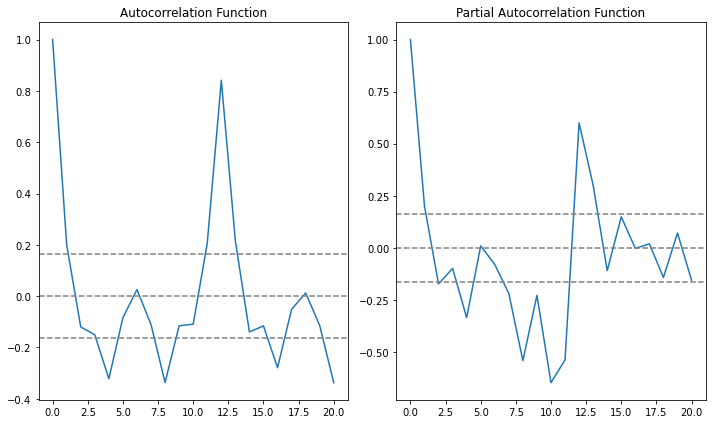

In [51]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_log_DiffShifting, nlags=20)
lag_pacf = pacf(df_log_DiffShifting, nlags=20, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_DiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_DiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

From above, we can define the values of P & Q as the value on the x-axis where there graphs touch the origin for the first time. P & Q values are approximately equal to 2.

Now, we know the values of P,D and Q: P=2, D=1, Q=2.

### AR model

C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting AR model


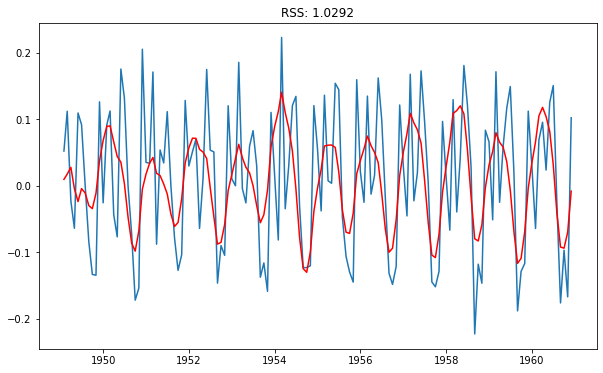

In [62]:
from statsmodels.tsa.arima_model import ARIMA

# AR model
model = ARIMA(ind_df_logscale, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(df_log_DiffShifting)
plt.plot(results_AR.fittedvalues, color='r')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - df_log_DiffShifting['#Passengers'])**2))
print('Plotting AR model')

Let's observe the value of RSS by changing the values of P,Q & D. RSS should have a smaller value.

Plotting AR model


C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


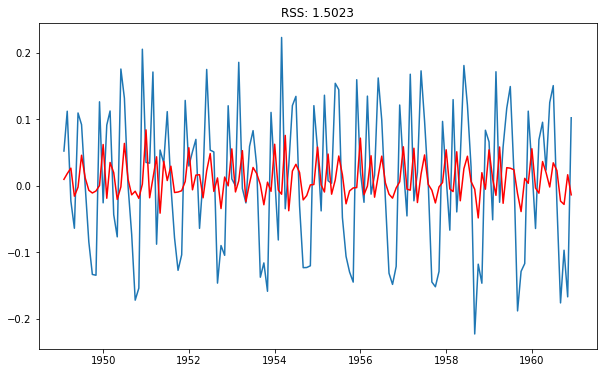

In [53]:
model = ARIMA(ind_df_logscale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(df_log_DiffShifting)
plt.plot(results_AR.fittedvalues, color='r')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - df_log_DiffShifting['#Passengers'])**2))
print('Plotting AR model')

C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting AR model


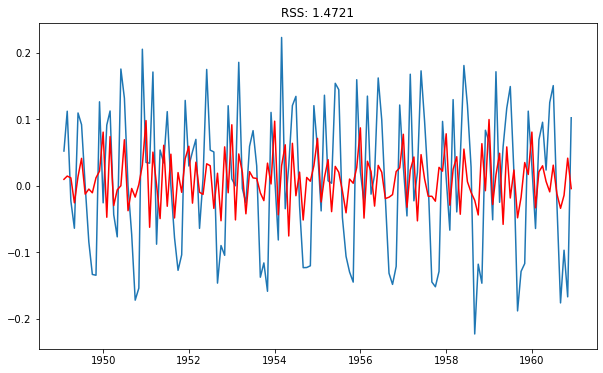

In [54]:
model = ARIMA(ind_df_logscale, order=(0,1,2))
results_AR = model.fit(disp=-1)
plt.plot(df_log_DiffShifting)
plt.plot(results_AR.fittedvalues, color='r')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - df_log_DiffShifting['#Passengers'])**2))
print('Plotting AR model')

### MA model

C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting AR model


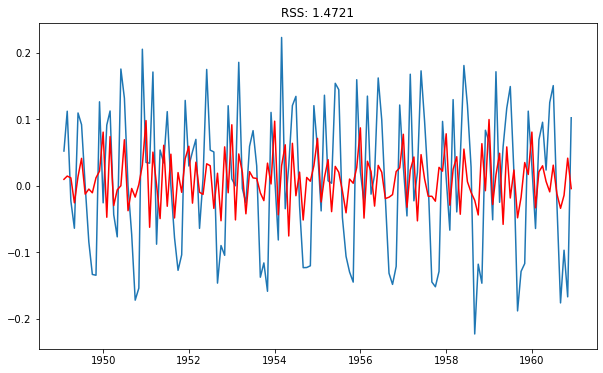

In [57]:
model = ARIMA(ind_df_logscale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(df_log_DiffShifting)
plt.plot(results_MA.fittedvalues, color='r')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - df_log_DiffShifting['#Passengers'])**2))
print('Plotting AR model')

### ARIMA model

C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\podug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting ARIMA model


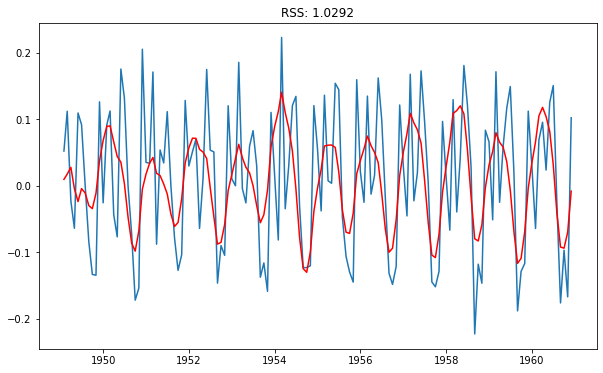

In [63]:
model = ARIMA(ind_df_logscale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(df_log_DiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='r')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - df_log_DiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [65]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [66]:
# Convert to cumulative sum

pred_AROMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
pred_AROMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [70]:
pred_ARIMA_log = pd.Series(ind_df_logscale['#Passengers'].index[0], index=ind_df_logscale.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_AROMA_diff_cumsum, fill_value=0)
pred_ARIMA_log.head()

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [69]:
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(indexed_df)
plt.plot(pred_ARIMA)

TypeError: ufunc 'exp' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [71]:
ind_df_logscale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


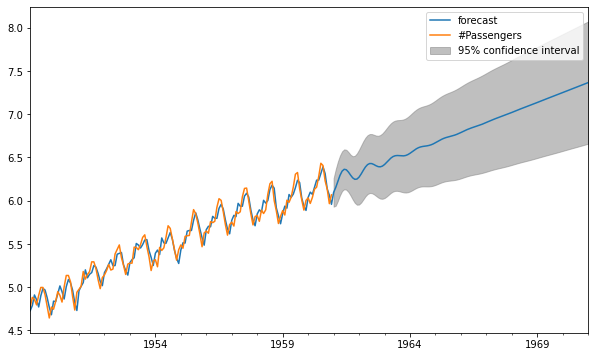

In [72]:
results_ARIMA.plot_predict(1,264)
x = results_ARIMA.forecast(steps=120)

In [73]:
x[1]

array([0.08384711, 0.10749464, 0.11568699, 0.1170278 , 0.11703502,
       0.11744022, 0.11762254, 0.11778718, 0.12024168, 0.12736049,
       0.13870969, 0.15118804, 0.16157827, 0.1683441 , 0.17177345,
       0.17311999, 0.17358749, 0.17385476, 0.17430234, 0.17543348,
       0.17788164, 0.1819574 , 0.18726237, 0.19283415, 0.19769269,
       0.20130665, 0.20369081, 0.20519858, 0.20625295, 0.20721025,
       0.20836997, 0.21000353, 0.21229771, 0.21524506, 0.21860208,
       0.22198287, 0.22503096, 0.22755327, 0.22954839, 0.23114831,
       0.23253858, 0.23390567, 0.23541343, 0.23718345, 0.23926572,
       0.24161572, 0.24410406, 0.24656393, 0.24885293, 0.25089667,
       0.25269771, 0.25431666, 0.2558435 , 0.25737266, 0.25898428,
       0.26072888, 0.26261587, 0.26461129, 0.26664938, 0.26865522,
       0.2705689 , 0.27236138, 0.27403743, 0.27562816, 0.27717872,
       0.27873569, 0.28033634, 0.28200061, 0.28372726, 0.28549554,
       0.28727255, 0.2890239 , 0.29072382, 0.29236128, 0.29394

In [74]:
len(x[1])

120

In [75]:
np.exp(x[1])

array([1.08746262, 1.11348489, 1.12264442, 1.12415069, 1.1241588 ,
       1.1246144 , 1.12481946, 1.12500466, 1.12776938, 1.1358264 ,
       1.14879054, 1.16321537, 1.17536445, 1.18334373, 1.1874088 ,
       1.18900876, 1.18956475, 1.18988273, 1.19041542, 1.19176271,
       1.19468391, 1.1995631 , 1.20594365, 1.21268166, 1.21858785,
       1.22299974, 1.22591905, 1.22776886, 1.22906405, 1.2302412 ,
       1.23166877, 1.23368241, 1.23651595, 1.24016578, 1.24433603,
       1.24854999, 1.25236149, 1.25552432, 1.25803175, 1.2600461 ,
       1.26179913, 1.2635253 , 1.26543183, 1.26767365, 1.27031603,
       1.2733048 , 1.27647716, 1.27962099, 1.28255339, 1.28517728,
       1.28749402, 1.2895801 , 1.29155058, 1.29352708, 1.29561344,
       1.29787574, 1.30032713, 1.30292442, 1.30558261, 1.30820402,
       1.3107099 , 1.31306143, 1.31526403, 1.31735793, 1.31940215,
       1.32145802, 1.32357491, 1.32577953, 1.32807066, 1.33042114,
       1.33278741, 1.33512364, 1.33739517, 1.3395869 , 1.34170